In [1]:
import magic
import subprocess
try:
    import ipfsapi
except ModuleNotFoundError:
    import ipfsApi as ipfsapi
import re
import numpy as np
import myipfsapi
import matplotlib.pyplot as plt
from enum import Enum
from tempfile import NamedTemporaryFile
from textblob import TextBlob
from typing import List, Optional

api = myipfsapi.connect('127.0.0.1', 5001)

class IPFSHashType(Enum):
    DATA = 0
    DIR = 1
    ERR = 2

class WikiType(Enum):
    HTMLPAGE = 0
    CRAWLED = 1
    NONE = 2

class Source(Enum):
    DHT = 0
    WEB = 1


In [23]:
# from https://stackoverflow.com/questions/2281850/timeout-function-if-it-takes-too-long-to-finish

import signal

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

In [2]:
wiki_hashes = set()

with open("wikipedia_results.txt", "r") as f:
    for wiki_hash in f.read().split():
        wiki_hashes.add(wiki_hash)

In [42]:
done_hashes = {}
bad_hashes = [
    'zCT5htkeDzF9WSWfTFxUfXjUudd9WNckGmnUnBnWCo1u9wb7aiM1',
    'QmSEXfAyvLwsPpWEjzeFp3KHpadGDre2y7zxMVbY5cman1'
]
for h in bad_hashes:
    done_hashes[h] = None

In [27]:
class FileHash:
    ipfs_hash: str
    level: int
    hash_type: IPFSHashType = IPFSHashType.ERR
    refs = []
    source: Source
    file_type: str = ''
    wiki: WikiType = WikiType.NONE
    language_code: Optional[str] = None
    
    def __init__(self, ipfs_hash: str, source: Source, level: int = 0):
        try:
            self.ipfs_hash = ipfs_hash
            self.level = level
            self.source = source

            if ipfs_hash in done_hashes:
                return

            done_hashes[ipfs_hash] = self
            print("{} {}".format(len(done_hashes), ipfs_hash))
            self.readline()
        except Exception as e:
            print(ipfs_hash)
            print(e)

    def __str__(self) -> str:
        return '{} {} {}'.format(self.ipfs_hash, self.hash_type, self.file_type)

    def readline(self) -> None:
        try:
            with timeout(seconds=3):
                line = api.cat(self.ipfs_hash, length = 10000)
            self.hash_type = IPFSHashType.DATA
            self.set_file_type(line)
            self.set_wikipedia(line)
        except TimeoutError:
            done_hashes[self.ipfs_hash] = None
            return
        except myipfsapi.exceptions.Error as e:
            self.hash_type = IPFSHashType.DIR
            
            # Only go one level deep on the refs
            if self.level <= 1:
                self.add_refs()
    
    def add_refs(self):
        try:
            with timeout(seconds=3):
                res = api.ls(self.ipfs_hash)['Objects'][0]['Links']
        except TimeoutError:
            done_hashes[self.ipfs_hash] = None
            return
        
        res = map(lambda link: link['Hash'], res)
        for h in res:
            self.refs.append(FileHash(h, self.source, self.level + 1))
        
    def set_file_type(self, line: bytes):
        if self.hash_type != IPFSHashType.DATA:
            raise Exception('cannot get file type of non-file')
        f = NamedTemporaryFile()
        f.write(line)
        f.seek(0)
        self.file_type = magic.from_file(f.name);

    def set_wikipedia(self, line: bytes):
        if b'mediawiki' in line:
            self.wiki = WikiType.HTMLPAGE
            regex = r'.*(<p id=.*</p>).*'
            match = re.match(regex, str(line))
            if len(match.groups()) > 0:
                self.language_code = TextBlob(match.groups()[0]).detect_language()
        elif self.ipfs_hash in wiki_hashes:
            self.wiki = WikiType.CRAWLED
        

In [5]:
def analyze(source: Source, hashes: List[str]) -> None:
    for h in hashes:
        FileHash(h, source = source)

In [43]:
dht_hashes = []
with open("ipfs_dht_results.txt", "r") as f:
    for line in f.read().split('\n'):
        if line == '':
            continue
        if line[0] == ' ':  # only accept root hashes
            continue
        file_hash = line.split()[-1]
        dht_hashes.append(file_hash)
        
analyze(Source.DHT, dht_hashes)

3 QmbXM2h2ZUWTgwm4QWwGfVymRqy4XRNq88L8qiuGn91n4V
4 QmNb8n9aQncEZU9hULkQZycVBCEvnbNPG4cFw992KDvBYb
5 QmWjbzihPPVaBNRrboYhFBcpqLWGjyJysR9UJCLT3dCPCv
6 QmWA75VQn1zqxXziTeFDi7FXXqQe71nHaenT5k3YmUHjWz
7 zb2rhncL9aKqRJfX1YJeRh3ejoHrLfdtobC27MQcXBTWKjGyV
8 zb2rhcw53HcfzT4YnaKKChqGKKggL7X1Zgmd4ZJQkeQmPbxiF
9 zb2rhokijGgdSRe4bUbw2x3Ws9zXewx9RJ9QXRMjxgLuxMz83
10 zb2rhkhRLcgGwWNRu7g17xb2wqxAYTm4qaH3zwkLcK1CeeQFK
11 zb2rhgbBnpG5b4yxFAoPwxSd6FvKQBBsXeYxGTVDAVUdyTCcG
12 zb2rhbN4CWw9VLK5SJnotxexchemBnWxNqD1gYzQkzYuz37Z3
13 zb2rhjd7ZduUyDadkcVFnZVVmdUzVa7CHU4SwNqNd5JUL54sa
14 zb2rhd1wKCePUTNzuzzFcn5Etghfgtna1jaBYUDWydds66YZt
15 zb2rhaUitadBVKz52pQchiCNT3vGz2PCEe3DcdiZvz9Qb7LKD
16 zb2rhkAjTYFajPsXZaYP1HhzuhRtuqaAb8DEFzkLe2dSeFq8E
17 zb2rhbUM9tZR4bd1hjZifUgSi1DAoXHBbJ9YAkmjzA4uP1Q43
18 zb2rhn1oDyU1WmRTkEEVAVuufdapYsMQ8z1bVv3iY7LGq8ALP
19 zb2rhfr9tMUVgC87Zd9FMQRHKYAiwDvHwR4itrZNDrEiSnT5C
20 zb2rhfdvquFSeuWAfenvai2WX5iRXKNpsYVRKPdKLMAfex5kJ
21 zb2rhjAi2yvz5hdthamuxuBm36Ep5ZFcqshC7C28hQFVpnNHW
22 zb2rhiwwg

164 zb2rhg52D6BcUckmYrqknuAH9n2T8aKJor9Hf4rh3syLBnvQF
165 zb2rhZe3Ed6nhkr21798Evn4CMZ51Bd33884gYmd8KY1tzBGK
166 zb2rhaDpogXxELEaCHttBMNGEjcVjmP51XXD3KwvTb9nCqtau
167 zb2rhnBV7v66Dy5R3xX7hvoo69CvwiHJgBfVH4sDT6zPS3G8q
168 zb2rhmvtBefFxq5XTBgHTGUdgnWw9qLYQsji744B1G7DnQQf9
169 zb2rhZurykfB8dHaMp6rJZD3NgVv6Y5dbHEUzzRcrK1ppE8xq
170 zb2rhf662umvTzKwGkDPvsUo9PPUc6Q1CmjMZAacrGw3qN2Sd
171 zb2rhYFHnqFnvkroP7xp2zY2US8cjJJmoo7PxQvsbktjAZFEK
172 zb2rhaNfrnGgmpx5mZfFg4oeQEK6jrxznr8kbtpsquGjoBU8o
173 zb2rhWgv193BiZzLj5CVvPkdFt3njeyCdivHHnTsB6Q715nad
174 zb2rhnDoQ7a6SBTfb4KGSvZjApQy3VvJAwarVosck3D8Y3xbg
175 zb2rhkNw85m8UvwkBPb17GTAV3fDS9Msj6yF2Xq883Zuf7FQk
176 zb2rhh7xiJiyKkQFJunNvVFz3Df4vJQGh9mXCzVuZWRuRbGib
177 zb2rhnbHtoijah9qtMto9Xn8LE9FCxwGSxjSLeNnmZn7e3GL3
178 zb2rhbjcs6mWiCLvLn7CeJah2ZHCaikJDFVVpbmYvr733s81h
179 zb2rhXXVCSwSAaN2SRQ7MQ3wmXAXPfkmZBUcHz77HkapE5tkM
180 zb2rhi5mWT9PtGrn2rML47FmEY16yeg1XG31Jr9ycwdqCfkXV
181 zb2rhXCmd8joKDMNQimPmrsPbuETZyzVZ4KEv2jjb5Chjfapf
182 zb2rhoN9VGPT5XKTDt7gcAHx

343 QmdiNigPuavgc8hSSiLgixzUcjAfLh6bU1EFskgUtCkSWx
344 QmcPK7AoPFa792pC3CfBAJYA8KnmFpPDhZviZfYB9ZJkJq
345 zb2rhZDA7nG1kTLS5hJEUrgeGrRWf5j3MfRTFpwNYdwba2hPZ
346 QmaerhvPUKUpr5M3urF9Xx3Ku3XBGVQkxVWL4rrqWCcfAu
347 QmWm5ATSPVmUcynimxADTdMJ7XoMYBGZk2XTCYVeUz3dR4
348 QmWXdcHoQf1wjzpLyixMYXi1LBmy9jrp3u4u75ZzGuoQGt
349 QmYQCbzLcZov5Uc1rXoMgvbrAguZFCPYAyxi1Q8P5wdCYF
350 QmeyWKxBqhbghn1zetJzJXHJnzPdZqLzfeAHVgS7dWoFmx
351 QmZFqQvf36xhaZGg1Gu9wDXK4HPY1uW4HgQRvkW8d5QGKT
352 QmPJsq97eXfYZ4vnhv9Ce9FRDTcZCd7PeGTB4Nxr5sA1Bi
353 zb2rhXbGgugd8DWCkotTF6Jmgga8ZyyZ7wEAb4yUxqd7UvYbX
354 zb2rhjocNojMW79cdJ1922HAHHa214tPZh5qTzyQAoU1G4PcE
355 QmW39y2koj5UtCnXryGYwa82oJchggnSpYL5518TRuRoog
356 QmQzsHc3ovrA36v2P6SoQKSAPnmWU6JRVExobAXvXaCJCX
357 QmXn5wn9VKvbxuUS1ohyw7BJY1bV6DxsKNEK8PKaJiraes
358 zb2rhmZpYr4oBvuG3DBMGKqrFkEe1JkgvqYC22KB3Nou1CSMz
359 QmWJSeg1cU7ewWCPMHsdRFvsMACaohLEhrfwPHe1WqkipX
360 QmeFUvxZhJdG4ULcm5sEjMNWF6Fas6KJNoAbtnfShvM5pW
361 QmQoJStkVvS4atjgmPcKBAsiYHUxgzdYU8riPyZq8yEcqN
362 zb2rhZUZDnbUMfN

497 zb2rhoQJfma5Z6VHEVJ9EU7PckbfmhzGokfGe8CS5oBnXuR3v
498 zb2rhmdGE5GHzmRf7UrtN59ypqUZ5NJrCHZhh9U5zTHGjUp13
499 zb2rhYR8BUk7uEeVdbXJqfU8aYJvHXcTrXZm1HTmF4hrfuuHr
500 zb2rhobQ1SXd6qc8AtaFG1aYo7d1bRtTJm7qc3f7Aw43AvV42
501 zb2rhaPo7JVyp9mYt4Jh9pbA8WBiKG336EpsdMBzsCwHFtxdk
502 zb2rhkeFWLdPKxQL6zSDeJpWfe4kNxnvqTPyPv88e531VEKdb
503 zb2rhbtchCNoo1Rn7zXGSaffprPxQSRxzT9AAebXB2dvgHcLz
504 zb2rhnFNe3sMb49sPbrKTtpms8JDejodrEr6PgVnaPzLar9Lo
505 zb2rhguyiDXmn5GUje8JrMSdyTie3FQhmBdshHHrMgAbXM1kF
506 zb2rhXbT16vtumctCeoX3EEWJVLv1G9F1xa7gcfHQTfFgkWQL
507 zb2rhgN3vf5cXh44o7EPi3jcSGtGQ3nR1Hj19L7bmVqsUxj1i
508 zb2rhfo1tTRzYUaeHcpvJ4GYC2N72KXomtT76BjGy26vdbLNw
509 zb2rhmodVRDttQKr35mxbhsiYyv4WhWurmBUWaTYjReGPi1BN
510 zb2rhn1HFEviw5zEUmTdmh2era89iJcMyxp45rVT2dwGbDvid
511 zb2rhjtq9kKYE3zBYUf2UdECv3LpBZjE6Pxzri7kgASpFrAAG
512 zb2rhe9XfHS98BE6Mmi5UqaCZwSgf5TjWj1KQnrwSXTk35qq8
513 zb2rhh88Co8DXVQ8KyeJ49ZzHMStEWzsdg7uustdj4cSNsXmF
514 zb2rhYQutCkUdDDMbqNxW1CcGxZSM5XARZEiQS1HvW4mRa1bx
515 QmXGYGNXrgN16xGPQRWpDw3d

652 zb2rhXq1QFB3Li1qLJKLeYrjBAUVG7g3wU9pJb1Yiab8bVesk
653 zb2rhk7HrybgEPDQjqRoy5AgX3fRwvc7UGpzcqxkmhoF8DehF
654 zb2rhcedVzpFDrz4inQDv6mxhdetwLfewfyQhxtFo9aQtpkG9
655 zb2rhm7wRAZtvUVQ6BcRFmzEdYB2QU5Saqk2mEc8mLPdivCJD
656 zb2rhdRbcgqaKjnKWoYDdghVoxD2wGvY7hgsQSq3BQFD7SH9u
657 zb2rhZL6EVHqY7NYn5jEd6pJ71X4zZsPJeMN9wY31cYhvbgm6
658 zb2rhmwsg4mfN5s6YQqL8yFFEDiX4eFWjipf9vK94gDt3n8bT
659 zb2rhkEyXUi7UfEUaTfA5amj4F8QPmutjpEUYdpsjNXYMQeYw
660 zb2rhXa1f4fHMiNzgJZ3jGAHbCNbTgbfXZu2BDvciXtqT4EoY
661 zb2rhiQRJGUZxosb6T9wWTvw6v2U2jrF3RHuAh5iW9UB3a6Gk
662 zb2rhgGraN9n1dNrfV3EthuDc1BAWbixS8UCWVprbGAf6Nw2e
663 zb2rhgLUaNWuupGuCCoUdtuqkm9eFX86BTWLnpdFrjoMHzKEq
664 zb2rhcHqST2xoa3N7kWtayEmsXdPtXG22JmPm6Fo5e4zzhMxP
665 zb2rhhRvvn2UN8ACRJstqwKLuDbjf7HRNWhpSKSiPqxrYg9ma
666 zb2rhheVH2nvNi99CV4D7eNPSKYeWtgTJ1jgaBZ17rPZYNW3b
667 zb2rhmQLg6TuLvHbLguqyakVrfhjenwCGecHC2NndnmG7qN2f
668 zb2rhiFgfAEgVGHg7y2bqLftatADLG3H5srN6duiopy5Bjzxx
669 zb2rhmnqcN7gFGgPZXy5AdVbpE1bxJ71EsbBccLtq8gacFooT
670 zb2rhb4Wxdj2covpbsz7uB29

807 zb2rhcpSVAV7XcBzw3zhvkRT4N8mDPGUxfVtaQdFpdHx5AgvE
808 zb2rhnDNmvwus2JRqNTafM9eUv6r5bGUzHJxEHNXywqem7Wnu
809 zb2rhcaxPA6tXTD22Tz6wCdgQLmXUw4LKroANZRfgxEB4BbMm
810 zb2rhcw65Vo5DYtUNDaEYARBSr6gV95bcoKsSokfhuUSu3M2t
811 zb2rhcsbdm898ouNjHkory7FUPeGZn1WUfKSWH2J8oSi2omfF
812 zb2rhhLKVt4VoPmyDDFjaSh5Dy7JnL3DzztUxGWijSUSoDZFM
813 zb2rhihbUH9mJbKttXMoULs7jRAGJVBLm8zTxZzcgCkqSjciu
814 zb2rhdPsNyF6hxznQ9eEwLDx39X1Jy9gUKPSmzj2vhmMd1b8V
815 zb2rhhz3wae8zevRVpeANGiTnWfYzrGfXaJNn8rsDFawfq4fW
816 zb2rhX1ffYdjSZseXfn9kz6jeR8Yw2oEERA23Wc61tQjuPkQh
817 zb2rhhLWj6mtC8KBJ94b9imDVASx93zVYgk6iTRfLMGr7MUUV
818 zb2rhniEsCxVPYPmkDtsM3qxv977Lz9vgFKrQQohrHzegE8cP
819 zb2rhfsxZtpYUx81jJPZ5fKg2uNFHcHaNvwUjw4b9wPrKJrSU
820 zb2rhagrpNqNLTZdZ6HdGM3Ggm3hMSmoAPk2v7szWRQckw79L
821 zb2rheqiNiLghvbmmAfZrj4rBU76D9K9MGAAUXDResnKxt7Zm
822 zb2rhYPzM1NfPCrwwgrScbCAVVExnf76GWXGrEMT1M59LCpWx
823 zb2rhenM5kwk1CsbAxT2ikFpmdRisqnbXA7oocACS9E1deGcx
824 zb2rhfDcYM9JXomFquwqPiqGC7kY6tezY5zjE9ZksgXu7b8ob
825 zb2rhiFk53sYQFX637LsxQjm

954 zb2rhjdNRXXFnJxzZMTJLa1RrRmpLvV2tXsn8Fd7U4FXNKntA
955 zb2rhYmkRN2aqYdq3mkA3BHFiK6TpT7D11TeCQFvLEuAd7NR6
956 zb2rhodZ5iwupjNkza8Vc2ijEAzoUyRuRDyVhQNih2nUQgC1Q
957 zb2rhXVuJo5o78bnXToepeu1vjJCyVePQrWaCHeWFVFoTyNf9
958 zb2rhntgcDz1sdq2NvG276XqVZpgm2M5JDL8rBsgzGuESYwMA
959 zb2rhWkSjskozCZqGSbGFAHexNA5gU72CDppqXpHVjXkJtAGg
960 zb2rhfUMACiNpwy7vrsxcYGqFjVsuEcK5SNeNiNo6SXxdt3My
961 zb2rhhxgZHZt8ERVJfyRv2bBHvPkntFZw24fdTQB1hfhcx5Ws
962 zb2rhZ9BNtPvH1hDhuDhTevUv1UFsNpGfjuXH1Um7nFYA7gPV
963 zb2rhdPm5dLvXJjYsbTRZQLPKavHnZ2Xe7wJp67dY78qE95GV
964 zb2rhhQBvTAhk4vqJtpnauFCDXBknXU7z7nuEcN4xXbFrpAbT
965 zb2rheoYbX61JT8iSuu15U8GiWdvyZyFwEgtyzC25dLNRxPCs
966 zb2rhaAQsniw9dUbFKio7ojq1dHHGYwsNRnRgvUGyLbRtpRRv
967 zb2rhWuo6y44CQadjFW6dskRNr17rqJ7LWCx4TicDsqtQYri3
968 zb2rhmxueV61uWdGGJaGMHVdfxjJyW2SrJhbFSCoSrEtYeS4B
969 zb2rhkUAtEEXHsNX6Z9SFuR3ffmuEbrN5YWx3RzEqMnZ41hNS
970 zb2rhXxbJggj1PrvLwNvx4oDsmHMBoiChq8sbNpnzR21B3jLS
971 zb2rhhkGB7NhUYhNqVLFFWJ5EVXo9BJjZSiXdggnEmtprKqgn
972 zb2rhYrwSaZg4wREriDLZdji

1105 zb2rhcGGCWZtNfMsEMYu25ipLcVGUdaGD53sP5pGTC2Dccqgm
1106 zb2rhfvf1Txdsj7aQiJXzySKfpq9VdNTDesT3um7KKDJtXYAW
1107 zb2rhk8cExsmZbupNPhN9v9MZBmmCEDZ2NBaAoUhYTcsU4yV9
1108 zb2rhk3JcKud1iqmWeMu4i5H4LrcnSP5kn1mYKf971ULTBHdU
1109 zb2rhmn4N9RmwojmF9LyPm4pxUbHCL5Xdff6B8E7ATDCsZ8Xk
1110 zb2rhfkpnrrwowQgsbZvqb2Tk2ZBmqmPNj1VNT7mpw5Qnuvwg
1111 zb2rhkc9Y2XZk9V9yEr2EH2sj1JfmcfRYAtXi3S1U2ZxJj9B8
1112 zb2rhak1DLjVd785d5uTk8bFjynDNTgYpVdMArexfME3MHfXa
1113 zb2rhn6hEqVyo2qWugZB3weMGWhJ6GkCVcaUvDkP6hVEtmZYK
1114 zb2rhi8XqCPcU4ZMAfFhxZ74r5We6KuFZcA24wVjusjZySwmF
1115 zb2rhjfAwr6huk4PBNuNY6mg1M9CmoT9U5pTxQR42QoP2Jmib
1116 zb2rhaVh4dsb1DSpsNzG8JKDj9QHWkFgC61eoD8RPjjikfS1i
1117 zb2rhfjKDV9RvRcBLeJKbUPvKnVXTDWRvuogDTv7MM4wK18oc
1118 zb2rhXPV36XRjreibnbBmyJq5vcFsTkBTxXWqoV5NQ99NQhy5
1119 zb2rhXGsB6vRBh5oN5WsuzNE9UbSmR1E5N7bjftN5YWag2ZYe
1120 zb2rhbkj2Ht76b7ATsFAXVbFa4KxCZAMM8CL3nTSsTVuy3wJt
1121 zb2rhbWMo7GGRbLuCwSPbGcv584YpenQoB2wg4NDLkfX1GRBH
1122 zb2rhZDiKL6gkvAx5s88igyjzCCSiZDGSqxjovStYF8W3EZCA
1123 zb2rh

1253 zb2rhgTYVby7nqo6CPgqcqfExbkbuvH9GrfqCGNcLCsHKq9br
1254 zb2rhnaRasWkj6SSPYW9VhkeArRPoeMD57M83HmGqTysqMJ3C
1255 zb2rhmasLe2ziLhFaKPFPUczymXrHWdTLfwQ5FKuHHZy8LqhD
1256 zb2rhidQ9UdPsR9HU7L5w2Vf387kbmjyZtWchLsBq7MwM2tu5
1257 zb2rhgSh28PidqK4PiNZ9KsZMf7GihYjxBgerfQ8eo6Jk5unZ
1258 zb2rhk5EgD5cZdwrN2zhP8zU8xJTB4gvJoWjRM3LeNzazB5zX
1259 zb2rha7HSjfQHhAEu6UpUaGPD5Cf3opc9m9yrzQNcW5eMmjua
1260 zb2rhYgcgzXDFPXPZ37xcHSem9k3pFuuJVBsAEgCSGYmuZeU2
1261 zb2rhkydEi64jNZ9BMqDo5WjRjGQY6BtBK3U3sBF3meQjF2S9
1262 zb2rhaGibNPfQwxoYzbfydFk9x9n1kHVwmJFrQQ1ufsaikEmx
1263 zb2rhoKmnvQVqd8pp9duexfQ6RUqJC5TbiB7mzoonCFjSr9Cn
1264 zb2rhZWhF3KztKaZoUKQiptXhX5Y1bRYKwvqTvMvKcUqDEWth
1265 zb2rha1SBKSsN3hMPx7ZEVjjXgJJMcoJ2fGGocEV3pPWUZ8S2
1266 zb2rhhKhCbHr2PNaePZ1CwvKYNWH3Ty7VCaUzrszLF2ZfCG2P
1267 zb2rhmPbP8AZVsJTPaY3YW8ivKSZGCsoC5pt2ZtWFzn5L9Qqg
1268 zb2rhcYzeMyKoVCYGW4WStpuqKAwJagK1Zm9LLp9ddBSSW9TE
1269 zb2rhbDtDS2QyYvJDmwSu1SF6jZ8PR5S3LxzA9ke8MaXTQx3T
1270 zb2rhkAeztMBBMYaFwLWxha6yx8EQk88dB8eGwgK54fJgCtLs
1271 zb2rh

In [44]:
web_hashes = []
with open("ipfs_web_crawl_hashes.txt", "r") as f:
    for line in f:
        web_hashes.append(line.strip())

analyze(Source.WEB, web_hashes)

1390 QmVNsFGDQPa2kJHUHxQmYJddzwDZdX2twpvwFF2jaChAix
1391 QmUDvnHPDiY6UhwNdEFHjkSd9wXpbdxwouvD2LA45ArSRV
1392 QmQgWmTQk6k67vB15LHGAhgNzc1nRu6K3YvektJmTPwSC5
1393 QmRjfsKV7yRAcFdMucuHSg4ARaoV1hHxTfjhTYigaznSxP
1394 QmQtTekDaG4475fqv8oVKanLo11C8rSKeVcbKee28WR1zd
1395 QmXrwF3CkqueC1RdzsJRZKYP2xCTHwsQzxesbPvzmVuKuT
1396 Qmf9S2zki1GsgMfAfYtYVMhofntEyThanac5mjRUtnMUKz
1397 Qma1A6LiskP9sSAw136nPbEqSRD3A7Z4QunCDZo8jzksxZ
1398 QmS4RToDPH6GgUJZHRcKVn88nvpnpt9UKdSJcP1NtwJvRZ
1399 QmTkzDwWqPbnAh5YiV5VwcTLnGdwSNsNTn2aDxdXBFca7D
1400 Qmd2xkBfEwEs9oMTk77A6jrsgurpF3ugXSg7dtPNFkcNMV
1401 QmeKozNssnkJ4NcyRidYgDY2jfRZqVEoRGfipkgath71bX
1402 QmZAL3oHMQYqsV61tGvoAVtQLs1WzRe1zkkamv9qxqnDuK
1403 QmZNPyKVriMsZwJSNXeQtVQSNU4v4KEKGUQaMT61LPahso
1404 QmSY8RfVntt3VdxWppv9w5hWgNrE31uctgTiYwKir8eXJY
1405 QmRosp97r8GGUEdj5Wvivrn5nBkuyajhRXFUcWCp5Zubbo
1406 QmNZiPk974vDsPmQii3YbrMKfi12KTSNM7XMiYyiea4VYZ
1407 QmebHHe3A3stxnPao6CfsQxwHDJrGV8PXEccE3MuZS3osw
1408 QmVsrcQiXGD1FNYeKxxVBLor1dmszvr1xnv6Jgq61jhhci
1409 QmV5ZVQ

1550 QmP8jTG1m9GSDJLCbeWhVSVgEzCPPwXRdCRuJtQ5Tz9Kc9
1551 QmWXShtJXt6Mw3FH7hVCQvR56xPcaEtSj4YFSGjp2QxA4v
1552 QmUh6QSTxDKX5qoNU1GoogbhTveQQV9JMeQjfFVchAtd5Q
1553 QmU7gJi6Bz3jrvbuVfB7zzXStLJrTHf6vWh8ZqkCsTGoRC
1554 QmRSxRRu9AoJ23bxb2pFeoAUFXMAdki7RZu2T7e6zHRdu6
1555 QmeQtZfwuq6aWRarY9P3L9MWhZ6QTonDe9ahWECGBZjyEJ
1556 QmRPGCmLKH2dQmNiPRsiuYS9EhhJL1Gmkz5F75gKY1K4Bm
1557 QmevXyY9HGCQ8GNdWU95pgW2h1mo2aWabtitkNStXfnnsJ
1558 QmRFMFGatjcX19qs9Zm1bemosWVbNiukJVXkhPCSH2hWh7
1559 QmTpZXUZicqEqVvVB76j1FdnMszEcgx4LHjURS8DiszRjS
1560 QmeWFWdyJo8hLnSEJNpEbKNnMHmFKS87DiZiYVbFJ5efhz
1561 QmRNUauWDvZFkAp1Bw3kAode3jT8aH2vx7LYzbS7H6R3Mg
1562 QmTJGHccriUtq3qf3bvAQUcDUHnBbHNJG2x2FYwYUecN43
1563 QmTGzzANxS5me2d74ppyUhsKhfroaDDDbeN1FdZqkShYVW
1564 QmVHGoXhcCNYmS3QmUkmkEPwvSXZp8BpXC25MfCyx99ZNy
1565 QmSxZ8Nxq4RJMhc2cxHXSymKSEGpwRYsg6TYZrGmfWyjdD
1566 QmNhFJjGcMPqpuYfxL62VVB9528NXqDNMFXiqN5bgFYiZ1
1567 QmNxF69vkC53ZBgXKHXBRbDWk2ELJeP5ohbPXtdYRRUgmN
1568 QmfUFkQuqjfQzLNhMLwiibiAxnAaZEJAbYkey9orXJ4aQe
1569 QmcJTRZ

ValueError: too many values to unpack (expected 2)

In [114]:
total_found = len([1 for _, fh in done_hashes.items() if fh is not None])
dht_found = len([1 for _, fh in done_hashes.items() if fh is not None and fh.source == Source.DHT])
web_found = len([1 for _, fh in done_hashes.items() if fh is not None and fh.source == Source.WEB])

dht_orig = len(dht_hashes)
web_orig = len(web_hashes)
dht_new = dht_found - dht_orig
web_new = web_found - web_orig

print(f'{total_found} total hashes found.')
print(f'{dht_found} ({dht_orig} + {dht_new}) dht hashes found.')
print(f'{web_found} ({web_orig} + {web_new}) web hashes found.')

1498 total hashes found.
1348 (278 + 1070) dht hashes found.
150 (71 + 79) web hashes found.


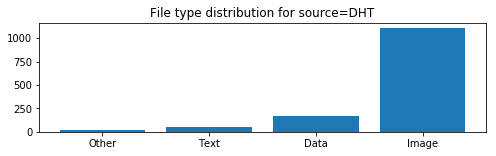

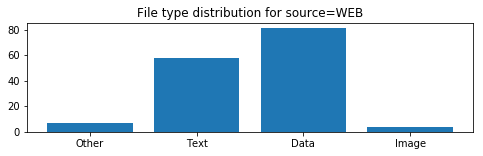

In [81]:
web_file_types = {}
dht_file_types = {}

def process_file_type(file_type):
    image_prefixes = ['JPEG', 'PNG', 'GIF', 'SVG']
    text_prefixes = ['ASCII text', 'UTF-8 Unicode', 'HTML']
    data_prefixes = ['data', 'gzip', 'empty']
    for prefix in image_prefixes:
        if file_type.startswith(prefix):
            return 'Image'
    for prefix in text_prefixes:
        if file_type.startswith(prefix):
            return 'Text'
    for prefix in data_prefixes:
        if file_type.startswith(prefix):
            return 'Data'
    if file_type == '':
        return 'Data'
    return 'Other'

for _, fh in done_hashes.items():
    if fh is None:
        continue
    file_type = process_file_type(fh.file_type)
    if fh.source == Source.DHT:
        file_types_dict = dht_file_types
    if fh.source == Source.WEB:
        file_types_dict = web_file_types
    if not file_type in file_types_dict:
        file_types_dict[file_type] = 0
    file_types_dict[file_type] += 1
    
dht_file_types_x = []
dht_file_types_y = []

for x,y in dht_file_types.items():
    dht_file_types_x.append(x)
    dht_file_types_y.append(y)
    
plt.figure(figsize=(8,2))
plt.bar(dht_file_types_x, dht_file_types_y)
plt.title('File type distribution for source=DHT')
    
web_file_types_x = []
web_file_types_y = []

for x,y in web_file_types.items():
    web_file_types_x.append(x)
    web_file_types_y.append(y)
    
web_file_types_y[0], web_file_types_y[2] = web_file_types_y[2], web_file_types_y[0]
    
plt.figure(figsize=(8,2))
plt.bar(dht_file_types_x, web_file_types_y)
plt.title('File type distribution for source=WEB');

file_types = {file_type: dht_file_types[file_type] + web_file_types[file_type] for file_type in dht_file_types_x}

28 Wikipedia pages found. (25.69%)
25
14 English Wikipedia pages found.
1 Kurdish Wikipedia pages found.
10 Turkish Wikipedia pages found.


Text(0.5,1,'Wikipedia language usage')

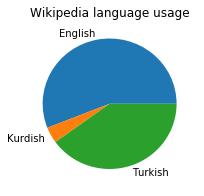

In [112]:
wiki_found = len([1 for _, fh in done_hashes.items() if fh is not None and fh.wiki == WikiType.HTMLPAGE])
print(f'{wiki_found} Wikipedia pages found. ({100 * wiki_found / file_types["Text"]:.2f}%)')

lang_found = len([1 for _, fh in done_hashes.items() if fh is not None and fh.language_code is not None])
print(lang_found)

en_found = len([1 for _, fh in done_hashes.items() if fh is not None and fh.language_code == 'en'])
kd_found = len([1 for _, fh in done_hashes.items() if fh is not None and fh.language_code == 'de'])
tr_found = len([1 for _, fh in done_hashes.items() if fh is not None and fh.language_code == 'tr'])

print(f'{en_found} English Wikipedia pages found.')
print(f'{kd_found} Kurdish Wikipedia pages found.')
print(f'{tr_found} Turkish Wikipedia pages found.')

plt.figure(figsize=(3,3))
plt.pie([en_found, kd_found, tr_found], labels=['English', 'Kurdish', 'Turkish']);
plt.title('Wikipedia language usage')